In [1]:
import imp
import os
import cv2
import pdb
import glob
import pandas as pd
import numpy as np
from tqdm import tqdm
from multiprocessing import Pool
import torch
from torch import Tensor
import torch.nn as nn
import torch.nn.functional as F
# from torch.nn.functional import InterpolationMode
import torchvision.models as models

In [2]:
gloss_df_path = "data_validation/processed_gloss.csv"
gloss_df = pd.read_csv(gloss_df_path)
gloss_df.dropna(inplace=True)

In [3]:
gloss_df.head()

,gloss,glossStart,glossEnd,fileName,sentenceID
0,MƏN,9.0,24.0,2022-07-18 16-41-51.mp4,70
1,EV,29.0,41.0,2022-07-18 16-41-51.mp4,70
2,YANMAQ,46.0,102.0,2022-07-18 16-41-51.mp4,70
3,EV,30.0,41.0,2022-07-20 14-09-03.mp4,70
4,YANMAQ,44.0,74.0,2022-07-20 14-09-03.mp4,70


In [4]:
gloss_df['glossRange'] = gloss_df['glossEnd'] - gloss_df['glossStart']
gloss_df.head()

,gloss,glossStart,glossEnd,fileName,sentenceID,glossRange
0,MƏN,9.0,24.0,2022-07-18 16-41-51.mp4,70,15.0
1,EV,29.0,41.0,2022-07-18 16-41-51.mp4,70,12.0
2,YANMAQ,46.0,102.0,2022-07-18 16-41-51.mp4,70,56.0
3,EV,30.0,41.0,2022-07-20 14-09-03.mp4,70,11.0
4,YANMAQ,44.0,74.0,2022-07-20 14-09-03.mp4,70,30.0


In [5]:
gloss_df.glossRange.mean()

21.5597629239381

In [6]:
def img_resize(img_path, dims=(256, 256)):
    img = cv2.imread(img_path)
    img = cv2.resize(img, dsize=dims)

    return img

In [7]:
gloss_df[pd.isnull(gloss_df['glossStart'])]

,gloss,glossStart,glossEnd,fileName,sentenceID,glossRange


In [8]:
num_classes = len(gloss_df.gloss.unique())
num_classes

234

In [9]:
from torchvision.models import squeezenet1_1, SqueezeNet1_1_Weights
from torchvision import transforms

In [10]:
# Image normalization transforms.
def normalize_transform(pretrained):
    if pretrained: # Normalization for pre-trained weights.
        normalize = transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
            )
    else: # Normalization when training from scratch.
        normalize = transforms.Normalize(
            mean=[0.5, 0.5, 0.5],
            std=[0.5, 0.5, 0.5]
        )
    return normalize
    
def get_train_transform(dims, pretrained):
    train_transform = transforms.Compose([
        transforms.Resize(dims),
        transforms.RandomHorizontalFlip(p=0.5),
        transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5)),
        transforms.RandomAdjustSharpness(sharpness_factor=2, p=0.5),
        transforms.ToTensor(),
        normalize_transform(pretrained)
    ])
    return train_transform

def get_valid_transform(IMAGE_SIZE, pretrained):
    valid_transform = transforms.Compose([
        transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
        transforms.ToTensor(),
        normalize_transform(pretrained)
    ])
    return valid_transform


In [11]:
weights = SqueezeNet1_1_Weights.IMAGENET1K_V1
model = squeezenet1_1(weights=weights)

In [12]:
model

SqueezeNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    (3): Fire(
      (squeeze): Conv2d(64, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace=True)
    )
    (4): Fire(
      (squeeze): Conv2d(128, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace=True)
    )
    (5): MaxPool2d

In [13]:
my_model = nn.Sequential(*list(model.children())[:])

In [14]:
my_model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    (3): Fire(
      (squeeze): Conv2d(64, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace=True)
    )
    (4): Fire(
      (squeeze): Conv2d(128, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace=True)
    )
    (5): MaxPool2d(kernel

In [15]:
preprocess = weights.transforms()

In [16]:
preprocess

ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [17]:
import cv2
import matplotlib.pyplot as plt
import PIL

In [18]:
from typing import Optional, Tuple

In [19]:
# class ImageClassification(nn.Module):
#     def __init__(
#         self,
#         *,
#         crop_size: int,
#         resize_size: int = 256,
#         mean: Tuple[float, ...] = (0.485, 0.456, 0.406),
#         std: Tuple[float, ...] = (0.229, 0.224, 0.225),
#         # interpolation: InterpolationMode = InterpolationMode.BILINEAR,
#     ) -> None:
#         super().__init__()
#         self.crop_size = [crop_size]
#         self.resize_size = [resize_size]
#         self.mean = list(mean)
#         self.std = list(std)
#         # self.interpolation = interpolation

#     def forward(self, img: Tensor) -> Tensor:
#         # img = F.resize(img, self.resize_size)
#         img = F.center_crop(img, self.crop_size)
#         if not isinstance(img, Tensor):
#             img = F.pil_to_tensor(img)
#         img = F.convert_image_dtype(img, torch.float)
#         # img = F.normalize(img, mean=self.mean, std=self.std)
#         return img

#     def __repr__(self) -> str:
#         format_string = self.__class__.__name__ + "("
#         format_string += f"\n    crop_size={self.crop_size}"
#         format_string += f"\n    resize_size={self.resize_size}"
#         format_string += f"\n    mean={self.mean}"
#         format_string += f"\n    std={self.std}"
#         # format_string += f"\n    interpolation={self.interpolation}"
#         format_string += "\n)"
#         return format_string

#     def describe(self) -> str:
#         return (
#             "Accepts ``PIL.Image``, batched ``(B, C, H, W)`` and single ``(C, H, W)`` image ``torch.Tensor`` objects. "
#             f"The images are resized to ``resize_size={self.resize_size}`` using ``interpolation={self.interpolation}``, "
#             f"followed by a central crop of ``crop_size={self.crop_size}``. Finally the values are first rescaled to "
#             f"``[0.0, 1.0]`` and then normalized using ``mean={self.mean}`` and ``std={self.std}``."
#         )


In [20]:
# from functools import partial
# transforms=ImageClassification(crop_size=224, resize_size=232)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<class 'numpy.ndarray'> (960, 1280, 3)
<class 'torch.Tensor'>
torch.Size([3, 224, 224])


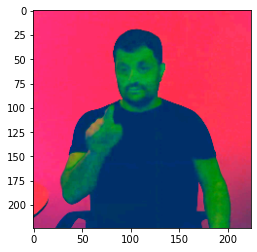

In [21]:
file_path = "../data/cam2/1/2022-04-25 13-29-56.mp4"

cap = cv2.VideoCapture(file_path)
cap.set(cv2.CAP_PROP_POS_FRAMES, 50)
res, img = cap.read()
img = cv2.cvtColor(img, cv2.COLOR_BGR2YCR_CB)
print(type(img), img.shape)
img = PIL.Image.fromarray(img)
# img = transforms.forward(img)
img = preprocess.forward(img)
print(type(img))

print(img.shape)
plt.imshow(img.permute(1, 2, 0))

In [22]:
file_path = "../data/cam2/1/2022-04-25 13-29-56.mp4"

cap = cv2.VideoCapture(file_path)
cap.set(cv2.CAP_PROP_POS_FRAMES, 50)
res, img = cap.read()
img = cv2.cvtColor(img, cv2.COLOR_BGR2YCR_CB)
img = PIL.Image.fromarray(img)
img = preprocess.forward(img)

dims = [1]
dims = dims + list(img.shape)
print(dims)
img = torch.reshape(img, dims)
# print(img.shape)
out = my_model(img)
out.shape

[1, 3, 224, 224]


torch.Size([1, 1000, 1, 1])

In [23]:
def frame_preprocess(img):
    """
    In:
    - img (numpy.ndarray): input image of shape [height, width, num_channels]
    Out:
    - (torch.Tensor): output Tensor of shape [num_channels, height, width]
    """

    img = PIL.Image.fromarray(img)
    preprocess = weights.transforms()
    img = preprocess.forward(img)

    return img

In [31]:
file_path = "../data/gloss/AD/2022-04-26 12-57-16.mp4"


# TO-DO: optimize conversion

cap = cv2.VideoCapture(file_path)
batch = []
ret = True

batch = []

while cap.isOpened() and ret:
    ret, frame = cap.read()
    if ret:
        batch.append(frame_preprocess(frame))

batch = torch.stack(batch)
flat_vf = my_model(batch)

flat_vf.shape

torch.Size([48, 1000, 1, 1])

In [25]:
batch.shape

torch.Size([48, 3, 224, 224])

In [27]:
flat_vf = my_model(batch)

flat_vf.shape

torch.Size([48, 1000, 1, 1])

In [41]:
new_batch = []
for i, img in enumerate(batch):
    new_batch.append(frame_preprocess(img))
    if i == 15:
        break

new_batch = torch.stack(new_batch)
flat_vf = my_model(new_batch)

flat_vf

tensor([[[[ 0.0509]],

         [[ 0.0684]],

         [[ 0.0445]],

         ...,

         [[ 0.1445]],

         [[ 0.0462]],

         [[-0.0397]]],


        [[[ 0.1108]],

         [[-0.0004]],

         [[ 0.0310]],

         ...,

         [[ 0.1021]],

         [[ 0.0639]],

         [[-0.0227]]],


        [[[ 0.0124]],

         [[ 0.0710]],

         [[ 0.0942]],

         ...,

         [[ 0.0532]],

         [[ 0.0075]],

         [[-0.0361]]],


        ...,


        [[[ 0.0366]],

         [[ 0.0911]],

         [[ 0.1835]],

         ...,

         [[-0.0259]],

         [[ 0.0036]],

         [[ 0.1675]]],


        [[[ 0.1531]],

         [[-0.0902]],

         [[ 0.1523]],

         ...,

         [[ 0.0149]],

         [[ 0.2754]],

         [[ 0.0921]]],


        [[[ 0.1446]],

         [[ 0.0014]],

         [[-0.0145]],

         ...,

         [[ 0.0144]],

         [[ 0.0117]],

         [[ 0.1444]]]], grad_fn=<MeanBackward1>)

In [42]:
flat_vf.shape

torch.Size([16, 2304, 1, 1])

In [43]:
len(batch)

221

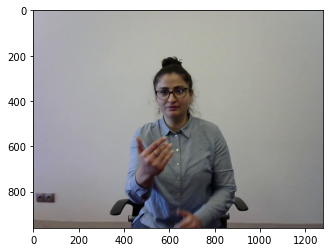

In [20]:
file_path = "../data/cam2/1/2022-05-26 11-15-10.mp4"

cap = cv2.VideoCapture(file_path)
cap.set(cv2.CAP_PROP_POS_FRAMES, 50)
res, img = cap.read()
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = PIL.Image.fromarray(img)
plt.imshow(np.asarray(img))

In [21]:
from modules.temp_conv import TemporalConv

In [22]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
device

device(type='cuda')

In [23]:
model.eval().to(device)

/home/toghrul/anaconda3/envs/sign-lang/lib/python3.9/site-packages/torch/cuda/__init__.py:146: UserWarning: 
NVIDIA RTX A5000 with CUDA capability sm_86 is not compatible with the current PyTorch installation.
The current PyTorch install supports CUDA capabilities sm_37 sm_50 sm_60 sm_70.
If you want to use the NVIDIA RTX A5000 GPU with PyTorch, please check the instructions at https://pytorch.org/get-started/locally/

  warnings.warn(incompatible_device_warn.format(device_name, capability, " ".join(arch_list), device_name))


EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 56, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(56, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(56, 56, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=56, bias=False)
            (1): BatchNorm2d(56, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(56, 14, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(14, 56, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormAct

In [24]:
import torchvision.models as models
from modules.temp_conv import TemporalConv

In [25]:
class SLRModel(nn.Model):
    def __init__(
        self, num_classes, c2d_type. conv_type, use_bn=False,
        hidden_size=1024, gloss_dict=None, loss_weights=None,
        weight_norm=True, share_classifier=True
    ):
    super(SLRModel, self).__init__()
    self.decoder = None
    self.loss = dict()
    self.criterion_init()
    self.num_classes = num_classes
    self.loss_weights = loss_weights
    self.conv2d = getattr(models, c2d_type)(pretrained=True)
    self.conv1d = TemporalConv(input_size=512,
                                   hidden_size=hidden_size,
                                   conv_type=conv_type,
                                   use_bn=use_bn,
                                   num_classes=num_classes)



    

SyntaxError: invalid syntax (3035282140.py, line 3)

In [ ]:
torch.cuda.device_count()

1

In [26]:
import torchvision
import torch.optim as optim

In [27]:
import os
import json
import cv2
import shutil

In [28]:
gloss_df

,gloss,glossStart,glossEnd,fileName,sentenceID,glossRange
0,MƏN,9.0,24.0,2022-07-18 16-41-51.mp4,70,15.0
1,EV,29.0,41.0,2022-07-18 16-41-51.mp4,70,12.0
2,YANMAQ,46.0,102.0,2022-07-18 16-41-51.mp4,70,56.0
3,EV,30.0,41.0,2022-07-20 14-09-03.mp4,70,11.0
4,YANMAQ,44.0,74.0,2022-07-20 14-09-03.mp4,70,30.0
...,...,...,...,...,...,...
9108,ALMIŞAM,104.0,139.0,2022-07-27 11-53-28.mp4,249,35.0
9109,OĞUL,44.0,61.0,2022-07-27 11-53-28.mp4,249,17.0
9110,ÜÇÜN,64.0,78.0,2022-07-27 11-53-28.mp4,249,14.0
9111,HƏDİYYƏ,81.0,97.0,2022-07-27 11-53-28.mp4,249,16.0


(array([111., 374., 602., 594., 509., 604., 568., 573., 579., 496., 515.,
        460., 348., 365., 326., 285., 280., 234., 170., 173., 152., 113.,
        111.,  98.,  60.,  59.,  53.,  41.,  38.,  25.,  36.,  21.,  14.,
         18.,  17.,  11.,  16.,   5.,   8.,   6.,   7.,   3.,   5.,   3.,
          2.,   3.,   3.,   3.,   2.,   4.]),
 array([  0.  ,   5.92,  11.84,  17.76,  23.68,  29.6 ,  35.52,  41.44,
         47.36,  53.28,  59.2 ,  65.12,  71.04,  76.96,  82.88,  88.8 ,
         94.72, 100.64, 106.56, 112.48, 118.4 , 124.32, 130.24, 136.16,
        142.08, 148.  , 153.92, 159.84, 165.76, 171.68, 177.6 , 183.52,
        189.44, 195.36, 201.28, 207.2 , 213.12, 219.04, 224.96, 230.88,
        236.8 , 242.72, 248.64, 254.56, 260.48, 266.4 , 272.32, 278.24,
        284.16, 290.08, 296.  ]),
 <BarContainer object of 50 artists>)

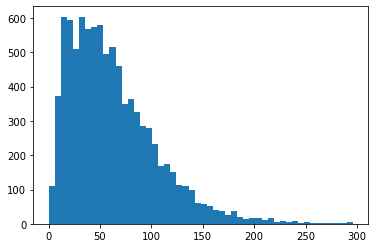

In [30]:
plt.hist(gloss_df[gloss_df.glossStart < 300]['glossStart'], bins=50)

In [ ]:
gloss_df.loc[0, 'glossStart']

9.0

In [31]:
cwd = os.path.dirname(os.path.abspath("tmp.ipynb"))
print(cwd)

/home/toghrul/SLR/sign-lang


In [35]:
read_src = '../data/cam2'
write_src = '../data/gloss/'

In [36]:
def video_to_frames(glossStart, glossEnd, video_path, size=None):
    """
    video_path -> str, path to video.
    size -> (int, int), width, height.
    """

    cap = cv2.VideoCapture(video_path)

    frames = []
    
    while True:
        res, frame = cap.read()
    
        if res:
            if size:
                frame = cv2.resize(frame, size)
            frames.append(frame)
        else:
            break

    cap.release()

    return frames[glossStart: glossEnd+1]

In [37]:
def convert_frames_to_video(frames, path_out, size, fps=15):
    writer = cv2.VideoWriter(path_out, cv2.VideoWriter_fourcc(*'mp4v'), fps, size)

    for frame in frames:
        # writing to a image array
        writer.write(frame)
    writer.release()

In [39]:
for gloss, df in gloss_df.groupby(by='gloss'):
    for i in range(len(df)):
        
        df.reset_index(drop=True, inplace=True)
        video_path = os.path.join(read_src, str(df.loc[i, 'sentenceID']), df.loc[i, 'fileName'])
        
        if os.path.exists(video_path):
            write_path = path_out = os.path.join(write_src, gloss)
            if not os.path.exists(write_path):
                os.mkdir(write_path)

            path_out = os.path.join(write_path, df.loc[i,'fileName'])
            
            frames = video_to_frames(int(df.loc[i, 'glossStart']),
                                        int(df.loc[i, 'glossEnd']),
                                        video_path,
            )

            size = frames[0].shape[:2][::-1]
            convert_frames_to_video(frames, path_out, size, fps=15)
            
            if os.path.exists(path_out):
                print(f">>> Created: {path_out}")
            else:
                print("sth wrong")
                break


>>> Created: ../data/gloss/AD/2022-07-16 11-23-12.mp4
>>> Created: ../data/gloss/AD/2022-07-13 14-27-01.mp4
>>> Created: ../data/gloss/AD/2022-07-20 16-22-17.mp4
>>> Created: ../data/gloss/AD/2022-08-01 12-42-31.mp4
>>> Created: ../data/gloss/AD/2022-05-24 15-41-33.mp4
>>> Created: ../data/gloss/AD/2022-07-22 13-28-59.mp4
>>> Created: ../data/gloss/AD/2022-05-25 13-19-19.mp4
>>> Created: ../data/gloss/AD/2022-05-26 11-15-10.mp4
>>> Created: ../data/gloss/AD/2022-07-02 17-35-35.mp4
>>> Created: ../data/gloss/AD/2022-07-02 17-35-35.mp4
>>> Created: ../data/gloss/AD/2022-04-26 12-57-16.mp4
>>> Created: ../data/gloss/AD/2022-07-15 14-49-32.mp4
>>> Created: ../data/gloss/AD/2022-05-24 16-23-20.mp4
>>> Created: ../data/gloss/AD/2022-07-29 18-42-40.mp4
>>> Created: ../data/gloss/AD/2022-08-01 13-51-05.mp4
>>> Created: ../data/gloss/AD/2022-05-21 16-22-50.mp4
>>> Created: ../data/gloss/AD/2022-07-19 11-41-19.mp4
>>> Created: ../data/gloss/AD/2022-07-02 14-37-25.mp4
>>> Created: ../data/gloss/A

In [31]:
int(11/2)

5

In [32]:
11//2

5

In [42]:
def get_n_params(model):
    pp=0
    for p in list(model.parameters()):
        nn = 1
        for s in list(p.size()):
            nn = nn*s
        pp += nn
    return pp

def get_stats():
    res = collections.defaultdict(dict)
    for x in pretrainedmodels.model_names:
        try:
            m = pm.__dict__[x](num_classes=1000, pretrained='imagenet')
            num_params = get_n_params(m)
            name_last, layer = list(m._modules.items())[-1]
            res[x]['n_params'] = num_params
            res[x]['feature_l_name'] = name_last
            res[x]['model_out_size'] = layer.in_features
        except:
            print('err', x)
    return res

_models = {
    'squeezenet1_0': { 'n_params': 1248424, 'feature_l_name': 'last_conv'},
    'squeezenet1_1': {'n_params': 1235496, 'feature_l_name': 'last_conv'},

    'vgg11_bn': { 'n_params': 123642856, 'feature_l_name': 'last_linear', 'model_out_size': 4096},
    'vgg13_bn': { 'n_params': 123642856, 'feature_l_name': 'last_linear', 'model_out_size': 4096},
    'vgg16_bn': { 'n_params': 123642856, 'feature_l_name': 'last_linear', 'model_out_size': 4096},
    'vgg19_bn': { 'n_params': 123642856, 'feature_l_name': 'last_linear', 'model_out_size': 4096},

    'vgg11': { 'n_params': 132863336, 'feature_l_name': 'last_linear', 'model_out_size': 4096},
    'vgg13': {'n_params': 123642856, 'feature_l_name': 'last_linear', 'model_out_size': 4096},
    'vgg16': { 'n_params': 123642856, 'feature_l_name': 'last_linear', 'model_out_size': 4096},
    'vgg19': { 'n_params': 123642856, 'feature_l_name': 'last_linear', 'model_out_size': 4096},

    'densenet121': { 'n_params': 7978856, 'feature_l_name': 'last_linear', 'model_out_size': 1024},
    'densenet161': {'n_params': 28681000, 'feature_l_name': 'last_linear', 'model_out_size': 2208},
    'densenet169':{ 'n_params': 14149480, 'feature_l_name': 'last_linear', 'model_out_size': 1664},
    'densenet201': { 'n_params': 20013928, 'feature_l_name': 'last_linear', 'model_out_size': 1920},


    'inceptionresnetv2': { 'n_params': 55843464, 'feature_l_name': 'last_linear', 'model_out_size': 1536},
    'inceptionv3': { 'n_params': 27161264, 'feature_l_name': 'last_linear', 'model_out_size': 2048},
    'inceptionv4': { 'n_params': 42679816, 'feature_l_name': 'last_linear', 'model_out_size': 1536},
    'bninception': {'n_params': 11295240, 'feature_l_name': 'last_linear', 'model_out_size': 1024},
    'xception': { 'n_params': 22855952, 'feature_l_name': 'last_linear', 'model_out_size': 2048},

    'dpn68': { 'n_params': 12611602, 'feature_l_name': 'classifier'},
    'dpn98': { 'n_params': 61570728, 'feature_l_name': 'classifier'},
    'dpn131': {'n_params': 79254504, 'feature_l_name': 'classifier'},

    'alexnet': { 'n_params': 61100840, 'feature_l_name': 'last_linear', 'model_out_size': 4096},

    'resnet18': { 'n_params': 11689512, 'feature_l_name': 'last_linear', 'model_out_size': 512},
    'resnet34': {'n_params': 21797672, 'feature_l_name': 'last_linear', 'model_out_size': 512},
    'resnet50': {'n_params': 25557032, 'feature_l_name': 'last_linear', 'model_out_size': 2048},
    'resnet101': { 'n_params': 44549160, 'feature_l_name': 'last_linear', 'model_out_size': 2048},
    'resnet152': { 'n_params': 60192808, 'feature_l_name': 'last_linear', 'model_out_size': 2048},

    'resnext101_32x4d': { 'n_params': 44177704, 'feature_l_name': 'last_linear', 'model_out_size': 2048},
    'resnext101_64x4d': { 'n_params': 83455272, 'feature_l_name': 'last_linear', 'model_out_size': 2048},
    'senet154': { 'n_params': 115088984, 'feature_l_name': 'last_linear', 'model_out_size': 2048},
    'fbresnet152': {'n_params': 60268520, 'feature_l_name': 'last_linear', 'model_out_size': 2048},

    'se_resnet50': { 'n_params': 28088024, 'feature_l_name': 'last_linear', 'model_out_size': 2048},
    'se_resnet101': { 'n_params': 49326872, 'feature_l_name': 'last_linear', 'model_out_size': 2048},

    'se_resnet152': { 'n_params': 66821848, 'feature_l_name': 'last_linear', 'model_out_size': 2048},
    'se_resnext50_32x4d': { 'n_params': 27559896, 'feature_l_name': 'last_linear',  'model_out_size': 2048},
    'se_resnext101_32x4d': {'n_params': 48955416, 'feature_l_name': 'last_linear', 'model_out_size': 2048},

    'nasnetalarge': {'n_params': 88753150, 'feature_l_name': 'last_linear', 'model_out_size': 4032},
    'nasnetamobile': {'n_params': 5289978, 'feature_l_name': 'last_linear', 'model_out_size': 1056},
}